## Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import tensorflow as tf
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Concatenate, LayerNormalization, GlobalAveragePooling1D, MultiHeadAttention, Flatten, BatchNormalization, MaxPooling1D, Flatten, LSTM, Bidirectional, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop, Adamax, AdamW
from keras.utils import to_categorical
from keras.regularizers import L1L2
from keras.initializers import RandomNormal, LecunUniform
from keras.constraints import UnitNorm, MinMaxNorm
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import ast

# Hide warnings
import warnings
warnings.filterwarnings("ignore")



## Data preparation

In [2]:
train_data = pd.read_csv('../../../Data/labelled_training_data.csv')
val_data = pd.read_csv('../../../Data/labelled_validation_data.csv')
test_data = pd.read_csv('../../../Data/labelled_testing_data.csv')

In [3]:
train_data["processId"] = train_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_data["parentProcessId"] = train_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
train_data["userId"] = train_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
train_data["mountNamespace"] = train_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
train_data["eventId"] = train_data["eventId"]  # Keep eventId values (requires knowing max value)
train_data["returnValue"] = train_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))


val_data["processId"] = val_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
val_data["parentProcessId"] = val_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
val_data["userId"] = val_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
val_data["mountNamespace"] = val_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
val_data["eventId"] = val_data["eventId"]  # Keep eventId values (requires knowing max value)
val_data["returnValue"] = val_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))


test_data["processId"] = test_data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
test_data["parentProcessId"] = test_data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
test_data["userId"] = test_data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
test_data["mountNamespace"] = test_data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
test_data["eventId"] = test_data["eventId"]  # Keep eventId values (requires knowing max value)
test_data["returnValue"] = test_data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))

In [4]:
train_data.describe()

,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus,evil
count,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.000000,763144.0
mean,1844.582673,0.978617,6820.265241,0.895755,0.001305,0.256371,288.158953,2.672082,0.340016,0.001663,0.0
std,1136.638249,0.144656,1937.068333,0.305578,0.036103,0.436629,385.117778,1.340906,0.533623,0.040744,0.0
min,132.560721,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.0
25%,903.250802,1.000000,7313.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0
50%,1829.203642,1.000000,7365.000000,1.000000,0.000000,0.000000,62.000000,3.000000,0.000000,0.000000,0.0
75%,2761.380825,1.000000,7415.000000,1.000000,0.000000,1.000000,257.000000,4.000000,1.000000,0.000000,0.0
max,3954.587643,1.000000,8619.000000,1.000000,1.000000,1.000000,1010.000000,5.000000,2.000000,1.000000,0.0


In [5]:
train_data.dtypes

timestamp          float64
processId            int64
threadId             int64
parentProcessId      int64
userId               int64
mountNamespace       int64
processName         object
hostName            object
eventId              int64
eventName           object
stackAddresses      object
argsNum              int64
returnValue          int64
args                object
sus                  int64
evil                 int64
dtype: object

### **Stackaddress**

In [6]:
stack_addresses_df = pd.concat([train_data['stackAddresses'], val_data['stackAddresses'], test_data['stackAddresses']], axis=0)
len(stack_addresses_df.unique())

112474

**Convert String to List**

In [7]:
# Convert string to list
train_data.stackAddresses = train_data.stackAddresses.apply(ast.literal_eval)
val_data.stackAddresses = val_data.stackAddresses.apply(ast.literal_eval)
test_data.stackAddresses = test_data.stackAddresses.apply(ast.literal_eval)
train_data.stackAddresses[0]

[140662171848350, 11649800180280676]

In [8]:
train_data['stack_address_len']=train_data.stackAddresses.apply(len)
val_data['stack_address_len']=val_data.stackAddresses.apply(len)
test_data['stack_address_len']=test_data.stackAddresses.apply(len)
print(f"Training dataset - Max length of stack addresses: {max(train_data['stack_address_len'])}")
print(f"Validation dataset - Max length of stack addresses: {max(val_data['stack_address_len'])}")
print(f"Testing dataset - Max length of stack addresses: {max(test_data['stack_address_len'])}")

Training dataset - Max length of stack addresses: 20
Validation dataset - Max length of stack addresses: 20
Testing dataset - Max length of stack addresses: 20


In [9]:
train_data['stack_address_len'].value_counts()

stack_address_len
0     521115
2     109594
1      65545
3      59301
4       2445
20      1406
14      1073
15       932
6        354
8        347
17       276
10       206
11       190
9        143
5         92
16        90
12        27
7          8
Name: count, dtype: int64

**Split list**

In [10]:
for i in range(max(train_data['stack_address_len'])):
    train_data[f"stack_{i+1}"]=""
    val_data[f"stack_{i+1}"]=""
    test_data[f"stack_{i+1}"]=""

In [11]:
for index, row in train_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        train_data.at[index, f'stack_{i+1}'] = elem

for index, row in val_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        val_data.at[index, f'stack_{i+1}'] = elem


for index, row in test_data.iterrows():
    list_stack = [float(elem) for elem in row['stackAddresses']]
    for i, elem in enumerate(list_stack):
        test_data.at[index, f'stack_{i+1}'] = elem

In [12]:
train_data.loc[0]

timestamp                                                  1809.495787
processId                                                            1
threadId                                                          7337
parentProcessId                                                      0
userId                                                               0
mountNamespace                                                       1
processName                                                      close
hostName                                               ip-10-100-1-120
eventId                                                            157
eventName                                                        prctl
stackAddresses                    [140662171848350, 11649800180280676]
argsNum                                                              5
returnValue                                                          0
args                 [{'name': 'option', 'type': 'int', 'value': 'P...
sus   

**Args**

In [13]:
train_data['argsNum'].value_counts()

argsNum
4    359113
1    230609
2    149273
3     20062
5      2678
0      1409
Name: count, dtype: int64

In [14]:
len(train_data['args'].unique())

214720

In [15]:
train_data['args'][4]

"[{'name': 'pathname', 'type': 'const char*', 'value': '/etc/ld.so.cache'}, {'name': 'flags', 'type': 'int', 'value': 'O_RDONLY|O_LARGEFILE'}, {'name': 'dev', 'type': 'dev_t', 'value': 211812353}, {'name': 'inode', 'type': 'unsigned long', 'value': 62841}]"

**Split args**

In [16]:
# Function to split the string column into list of dictionaries and create new columns
def split_and_expand(row):
    if pd.isna(row):
        return pd.Series([None] * 15)

    dicts = ast.literal_eval(row)
    result = {'name_{}'.format(i+1): None for i in range(5)}
    result.update({'type_{}'.format(i+1): None for i in range(5)})
    result.update({'value_{}'.format(i+1): None for i in range(5)})

    for i, d in enumerate(dicts):
        if i >= 5:
            break
        result['name_{}'.format(i+1)] = d.get('name')
        result['type_{}'.format(i+1)] = d.get('type')
        result['value_{}'.format(i+1)] = d.get('value')

    return pd.Series(result)

Training

In [17]:
args_split = train_data['args'].apply(split_and_expand)
train_data = pd.concat([train_data, args_split], axis=1)

Validation

In [18]:
args_split = val_data['args'].apply(split_and_expand)
val_data = pd.concat([val_data, args_split], axis=1)

Testing

In [19]:
args_split = test_data['args'].apply(split_and_expand)
test_data = pd.concat([test_data, args_split], axis=1)

**Features selection**

In [20]:
# data1 = train_data.sample(frac=0.4, ignore_index=True)

X_num_train = train_data[['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'stack_address_len']]
X_cat_train = train_data[['processName', 'hostName', 'eventName',
                     'stack_1', 'stack_2', 'stack_3', 'stack_4',
                     'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9',
                     'stack_10','stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                     'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20',
                     'name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                     'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                     'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype(str)

In [21]:
X_num_val = val_data[['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'stack_address_len']]
X_cat_val = val_data[['processName', 'hostName', 'eventName',
                     'stack_1', 'stack_2', 'stack_3', 'stack_4',
                     'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9',
                     'stack_10','stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                     'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20',
                     'name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                     'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                     'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype(str)

In [22]:
X_num_test = test_data[['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'argsNum', 'returnValue', 'stack_address_len']]
X_cat_test = test_data[['processName', 'hostName', 'eventName',
                     'stack_1', 'stack_2', 'stack_3', 'stack_4',
                     'stack_5', 'stack_6', 'stack_7', 'stack_8', 'stack_9',
                     'stack_10','stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                     'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20',
                     'name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                     'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                     'value_1', 'value_2', 'value_3', 'value_4', 'value_5']].astype(str)

In [23]:
y_train = train_data['sus']
y_val = val_data['sus']
y_test = test_data['sus']

In [24]:
y_train_encoded = to_categorical(y_train, num_classes=2)
y_val_encoded = to_categorical(y_val, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)
y_train_encoded

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

**Categorical features encoding**

Stack addresses

In [25]:
stack_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1, dtype=float)

# Encode Stack adresses
stackaddresses_train_enc = stack_ordinal_encoder.fit_transform(X_cat_train[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                                      'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                                      'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                                      'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']])

X_cat_train[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
             'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
             'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
             'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']] = stackaddresses_train_enc

In [26]:
stackaddresses_val_enc = stack_ordinal_encoder.transform(X_cat_val[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                        'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                        'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                        'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']])
stackaddresses_val_enc = np.where(stackaddresses_val_enc==-1, np.max(stackaddresses_train_enc)+1, stackaddresses_val_enc)
X_cat_val[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
           'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
           'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
           'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']]= stackaddresses_val_enc

In [27]:
stackaddresses_test_enc = stack_ordinal_encoder.transform(X_cat_test[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
                                                        'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
                                                        'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
                                                        'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']])

stackaddresses_test_enc = np.where(stackaddresses_test_enc==-1, np.max(stackaddresses_train_enc)+1, stackaddresses_test_enc)

X_cat_test[['stack_1', 'stack_2', 'stack_3', 'stack_4', 'stack_5',
           'stack_6', 'stack_7', 'stack_8', 'stack_9', 'stack_10',
           'stack_11', 'stack_12', 'stack_13', 'stack_14', 'stack_15',
           'stack_16','stack_17', 'stack_18', 'stack_19', 'stack_20']]= stackaddresses_test_enc

In [28]:
stackaddresses_train_enc.shape

(763144, 20)

Args

In [29]:
# Encode Stack adresses
args_ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=float)
args_train_enc = args_ordinal_encoder.fit_transform(X_cat_train[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                            'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                            'value_1', 'value_2', 'value_3', 'value_4', 'value_5']])
X_cat_train[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
             'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
             'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_train_enc

In [30]:
args_val_enc = args_ordinal_encoder.transform(X_cat_val[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                    'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                    'value_1', 'value_2', 'value_3', 'value_4', 'value_5']])

args_val_enc = np.where(args_val_enc==-1, np.max(args_train_enc)+1, args_val_enc)

X_cat_val[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
           'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
           'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_val_enc

In [31]:
args_test_enc = args_ordinal_encoder.transform(X_cat_test[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
                                                      'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
                                                      'value_1', 'value_2', 'value_3', 'value_4', 'value_5']])

args_test_enc = np.where(args_test_enc==-1, np.max(args_train_enc)+1, args_test_enc)

X_cat_test[['name_1', 'name_2', 'name_3', 'name_4', 'name_5',
           'type_1', 'type_2', 'type_3', 'type_4', 'type_5',
           'value_1', 'value_2', 'value_3', 'value_4', 'value_5']] = args_test_enc

**Scaler**

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_val_scaled = scaler.transform(X_num_val)
X_num_test_scaled = scaler.transform(X_num_test)

# X_train_scaled=np.concatenate((X_num_train_scaled,X_cat_train),axis=1)
# X_val_scaled=np.concatenate((X_num_val_scaled,X_cat_val),axis=1)
# X_test_scaled=np.concatenate((X_num_test_scaled,X_cat_test),axis=1)

## Modelisation

In [33]:
n_unique_stack = (np.max(stackaddresses_train_enc)+2).astype('int')
n_unique_args = (np.max(args_train_enc)+2).astype('int')
n_unique_stack,n_unique_args

(8449, 26665)

In [34]:
X_num_train.shape

(763144, 9)

In [65]:
def create_transformer_model(input_cat1_shape, input_cat2_shape, input_num_shape, input_cat1_vocab, input_cat2_vocab, max_len=10, num_transformer_layers=4): #input_cat3_shape, input_cat4_shape, input_cat5_shape

  # Define categorical input layers
  input_cat1 = Input(shape=(input_cat1_shape,))
  input_cat2 = Input(shape=(input_cat2_shape,))
  input_num = Input(shape=(input_num_shape,))

  # Define embedding layers
  embedding_size = 256
  embedding_size2 = 128
  embed_cat1 = Embedding(input_dim=input_cat1_vocab,
                         output_dim=embedding_size,
                         embeddings_initializer = LecunUniform(seed=41),
                         embeddings_constraint  = MinMaxNorm(axis=[0,1]),
                         mask_zero=False)(input_cat1)
  embed_cat1 = Dense(embedding_size2, activation='linear')(embed_cat1)
  embed_cat2 = Embedding(input_dim=input_cat2_vocab,
                         output_dim=embedding_size,
                         embeddings_initializer = LecunUniform(seed=41),
                         embeddings_constraint  = MinMaxNorm(axis=[0,1]),
                         mask_zero=False)(input_cat2)
  embed_cat2 = Dense(embedding_size2, activation='linear')(embed_cat2)

  # Dense for numerical inputs
  embed_num = Dense(embedding_size2, activation='linear')(input_num)
  # Reshape numerical input using a Keras layer
  input_num_reshaped = Reshape(target_shape=(1, embedding_size2))(embed_num)

  # Concatenate embedding layers
  concat_embeds = Concatenate(axis=1)([embed_cat1, embed_cat2, input_num_reshaped]) #embed_cat3, embed_cat4, embed_cat5

  # Positional encoding (assuming you want to use sequences)
  max_len=36
  pos_encoding = PositionalEncoding(max_len, embedding_size2)(concat_embeds)

  # Transformer encoder block
  encoder_output = pos_encoding
  for _ in range(num_transformer_layers):
      encoder_output = transformer_encoder_block(encoder_output, num_heads=8, ff_dim=embedding_size2)
  # encoder_output = transformer_encoder_block(pos_encoding, num_heads=8, ff_dim=embedding_size2)

  # Global average pooling
  encoder_output = GlobalAveragePooling1D()(encoder_output)

  # Fully connected layers (remains unchanged)
  x = Dense(128, activation='relu')(encoder_output)
  x = Dropout(0.5)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(2, activation='softmax')(x)
  # Define model
  model = Model(inputs=[input_cat1, input_cat2, input_num], outputs=output) #input_cat3, input_cat4, input_cat5

  return model

def transformer_encoder_block(inputs, num_heads, ff_dim, dropout_rate=0.2, embedding_size=128):
    # Multi-head self-attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_size)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-4)(inputs + attention)

    # Feed-forward layer
    outputs = Dense(ff_dim, activation='relu')(attention)
    outputs = Dropout(dropout_rate)(outputs)
    outputs = LayerNormalization(epsilon=1e-4)(attention + outputs)

    return outputs

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.positional_encoding = self.positional_encoding(sequence_length, output_dim)

    def call(self, inputs):
        return inputs + self.positional_encoding

    def positional_encoding(self, sequence_length, output_dim):
        encoded_vec = np.array([pos / np.power(10000, 2 * i / output_dim) for pos in range(sequence_length) for i in range(output_dim)])
        encoded_vec[::2] = np.sin(encoded_vec[::2])
        encoded_vec[1::2] = np.cos(encoded_vec[1::2])
        return tf.constant(encoded_vec.reshape([sequence_length, output_dim]), dtype=tf.float32)

# Example usage
input_cat1_shape = 20
input_cat2_shape = 15
input_cat3_shape = 1
input_cat4_shape = 1
input_cat5_shape = 1
input_num_shape = 9
num_transformer_layers=4


model = create_transformer_model(input_cat1_shape, input_cat2_shape, input_num_shape, n_unique_stack, n_unique_args,num_transformer_layers=num_transformer_layers)
#input_cat3_shape, input_cat4_shape, input_cat5_shape
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 20, 256)   │  2,162,944 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 15, 256)   │  6,826,240 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 128)       │      1,280 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 20, 128)   │     32,896 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 15, 128)   │     32,896 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 128)    │          0 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 36, 128)   │          0 │ dense_21[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0],   │
│                     │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 36, 128)   │          0 │ concatenate_3[0]… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 36, 128)   │    527,488 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 36, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 36, 128)   │          0 │ positional_encod… │
│                     │                   │            │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 36, 128)   │        256 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 36, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 36, 128)   │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 36, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_24[0][0]

 Total params: 11,255,010 (42.93 MB)

 Trainable params: 11,255,010 (42.93 MB)

 Non-trainable params: 0 (0.00 B)

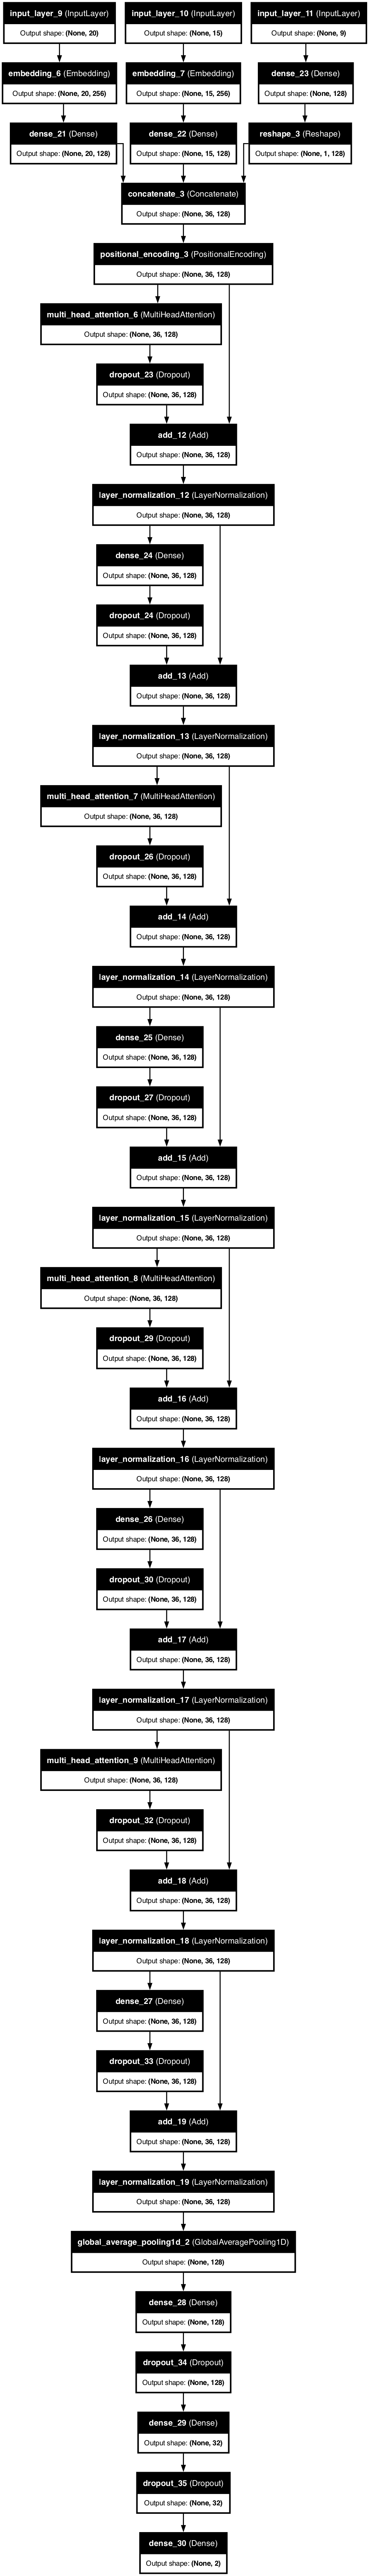

In [66]:
plot_model(model, to_file='../../pics/Transformer-structure.png', show_shapes=True, show_layer_names=True, dpi=100)

In [67]:
# optimizer = AdamW(learning_rate=0.0001, weight_decay=0.001)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callback = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=False)

# Train the model
history = model.fit([X_cat_train.iloc[:,3:23],
                     X_cat_train.iloc[:,23:44],
                     X_num_train_scaled],  # Input data
                    y_train_encoded,  # Labels
                    epochs=10,  # Number of epochs
                    batch_size=512,  # Batch size
                    validation_data=([X_cat_val.iloc[:,3:23],
                                      X_cat_val.iloc[:,23:44],
                                      X_num_val_scaled],
                                     y_val_encoded),
                    verbose=1, shuffle=True, callbacks = [callback])

Epoch 1/10
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 2020s 1s/step - accuracy: 0.9942 - loss: 0.0218 - val_accuracy: 1.0000 - val_loss: 7.2092e-04
Epoch 2/10
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 1994s 1s/step - accuracy: 0.9997 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 6.0084e-04
Epoch 3/10
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 3328s 2s/step - accuracy: 0.9996 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 6.0499e-04
Epoch 4/10
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 2004s 1s/step - accuracy: 0.9997 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 6.4319e-04
Epoch 5/10
1491/1491 ━━━━━━━━━━━━━━━━━━━━ 4988s 3s/step - accuracy: 0.9997 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 5.6108e-04


In [68]:
def plot_training(history):
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get the training and validation loss
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Plot the accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot the loss
    plt.figure(figsize=(8, 4))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    return(plt)

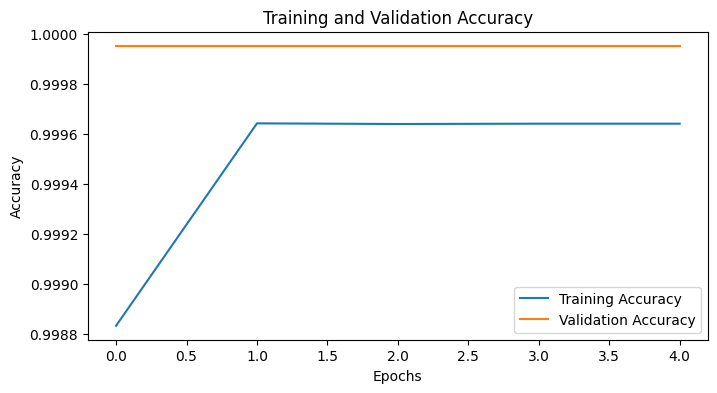

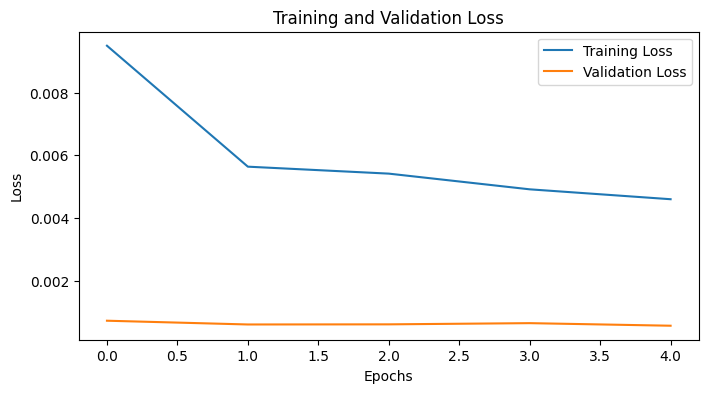

In [69]:
plot_training(history);

In [70]:
pred = model.predict([X_cat_test.iloc[:,3:23],
                      X_cat_test.iloc[:,23:44],
                      X_num_test_scaled],
                     batch_size=256)

739/739 ━━━━━━━━━━━━━━━━━━━━ 199s 269ms/step


In [71]:
# pred_threshold = np.where(pred>0.5,1,0)
pred_threshold = np.argmax(pred, axis=1)

In [72]:
print(classification_report(y_test, pred_threshold, target_names=['Unsuspicious', 'Suspicious']))

              precision    recall  f1-score   support

Unsuspicious       0.63      1.00      0.77     17508
  Suspicious       1.00      0.94      0.97    171459

    accuracy                           0.95    188967
   macro avg       0.82      0.97      0.87    188967
weighted avg       0.97      0.95      0.95    188967



In [61]:
confusion_matrix(y_true=y_test, y_pred=pred_threshold)

array([[ 17508,      0],
       [ 10208, 161251]])

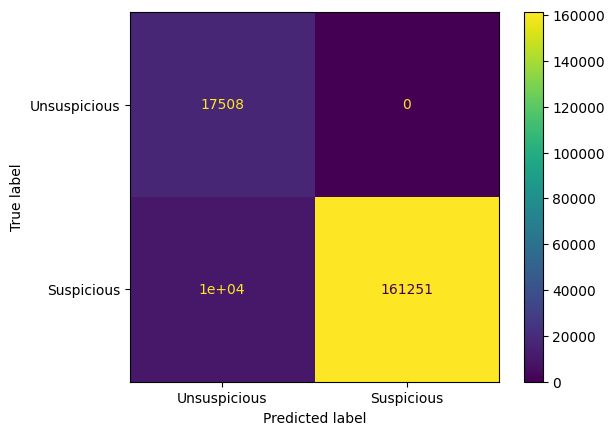

In [73]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=pred_threshold)
x=ConfusionMatrixDisplay(conf_matrix, display_labels=['Unsuspicious', 'Suspicious']).plot()

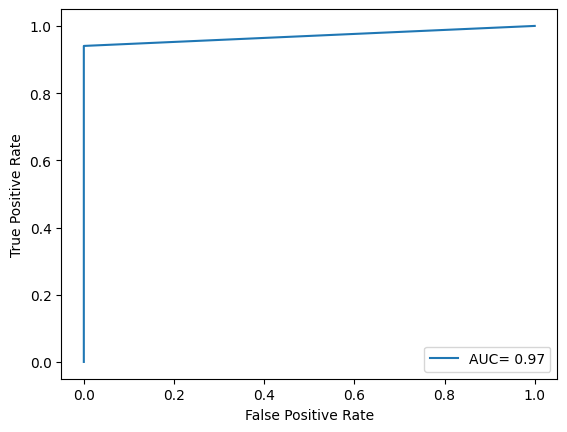

In [74]:
auroc = roc_auc_score(y_true=y_test, y_score=pred_threshold)
fpr, tpr, _ = roc_curve(y_test, pred_threshold)
plt.plot(fpr,tpr,label=f"AUC= {auroc:.2f}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()